In [25]:
# 0. ---------------------import library---------------------
import numpy as np
import pandas as pd

from scipy import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf

import matplotlib
import matplotlib.pyplot as plt
import japanize_matplotlib
# for hiragana, katakana, kanji of japanese 

%matplotlib inline 
import seaborn as sns
plt.style.use("ggplot")

import os
import openpyxl

import collections, csv
from os.path  import basename

import glob                        

import itertools
from itertools import chain, repeat
from itertools import cycle, islice

# def duplication function 
def duplicate(testList, n):
    return testList*n

In [ ]:
# 목적1: 선박 경로 예측 -> 예측 대상: 위도, 경도(Latitude, Longitude)
# 목적2: 선박 운전 효율지표 생성
# 목적3: 현 경로/예측 경로 가시화 및, 효율 지표 가시화 
#       데이터1: 선박위치데이터 = df1
#       데이터2: 선박기기데이터 = df2
#       데이터3: 데이터1+데이터2 = df3 
#       예측1: 시계열 이동평균으로, 위도/경도 예측
#       예측2: 혹은 [distance, bearing]를 예측 후, 위도/경도를 계산 * 결과적으로 배제

#*주의* 데이터 셋 타임라인 1달 ->  시계열 예측의 어려움이 예상됨

In [2]:
# ----------------목적1.0 read data-------------------------------------------------------
#데이터1: 선박위치데이터

df1=pd.read_csv("localpath",encoding="cp932")


In [4]:
# ---------------목적1.1. data cleansing-------------------------------------
# latitude,longitude->정수화（from DMS to [Decimal Degree]）
def convert(tude):
    multiplier = 1 if tude[-1] in ['N', 'E'] else -1
    return multiplier * sum(float(x) / 60 ** n for n, x in enumerate(tude[:-1].split('-')))
lan49=[]
lon49=[]
for i in range(df1.shape[0]):
    a=np.array(df1['Latitude(緯度)'])
    b=convert(a[i])
    lan49.append(b)
for i in range(df1.shape[0]):
    a=np.array(df1['Longitude(経度)'])
    b=convert(a[i])
    lon49.append(b)
df1["Latitude"]=lan49
df1["Longitude"]=lon49
df1.drop(columns=['Latitude(緯度)', 'Longitude(経度)'],axis=1,inplace=True)

In [7]:
# ----------------목적1.2. Feature Engineering-------------------
# 예측2 distance 를 계산

In [6]:
from geopy.distance import geodesic

In [7]:
df1distance=[0]
for i in range(1,df1.shape[0]):
    a=(df1.Latitude[i-1],df1.Longitude[i-1])
    b=(df1.Latitude[i],df1.Longitude[i])
    c=geodesic(a,b).miles
    df1distance.append(c)

In [8]:
# distance변수 추가
df1["Distance"]=df1distance

In [9]:
# 예측2 bearing 를 계산
import math
df1bearing=[0]
for i in range(1,df1.shape[0]):
    lat0=df1.Latitude[i-1]
    lat1=df1.Latitude[i]
    lon0=df1.Longitude[i-1]
    lon1=df1.Latitude[i]
    tc=math.atan2(math.sin(lon1-lon0)*math.cos(lat1),
                  math.cos(lat0)*math.sin(lat1)-math.sin(lat0)*math.cos(lat1)*math.cos(lon1-lon0))
    
    df1bearing.append(tc)

In [10]:
# bearing변수 추가
df1["bearing"]=df1bearing

In [11]:
# --------------------------목적1.3.data 완성----------------------------
# ------it is not necessary to see skewdness----------------------------

In [12]:
df1_1=df1.copy()

In [13]:
#결손치 제거 /  필요한 변수만 남기기
df1_1["Course"].fillna(df1_1.Course.median(),inplace=True)
df1_1["Heading"].fillna(df1_1.Heading.median(),inplace=True)
df1_1['Lasttime(UTC+09:00)']= pd.to_datetime(df1_1['Lasttime(UTC+09:00)'])
df1_1.drop(columns="UTC",axis=1,inplace=True)

# df1_1float=df1_1.iloc[:,[7,8,9,11,12,13]]
#시계열 이동평균 예측을 위해, 시간빈도 조정: 빈도=1day with median
df1_3=df1_1.groupby([pd.Grouper(key='Lasttime(UTC+09:00)', freq='1D')])[['Course', 'Heading', 'Speed（船速）', 'Latitude',
       'Longitude','Distance',"bearing"]].median()

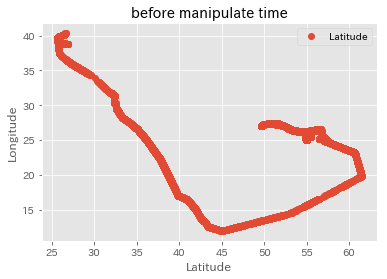

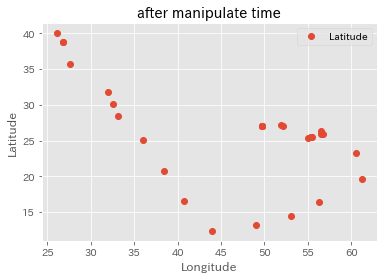

In [14]:
# # --------------------------목적1.5  EDA--------------------------

# 먼저 위도경도 가시화 
# 시간빈도 조정 전: before manipulate datetime span with median
df1_1.plot(x='Longitude', y='Latitude',style='o')  
plt.title('before manipulate time')  
plt.xlabel('Latitude')  
plt.ylabel('Longitude')  
plt.show()
# 시간빈도 조정 후:  after manipulate datetime span with median
df1_3.plot(x='Longitude', y='Latitude',style='o')  
plt.title('after manipulate time')  
plt.xlabel('Longitude')  
plt.ylabel('Latitude')  
plt.show()

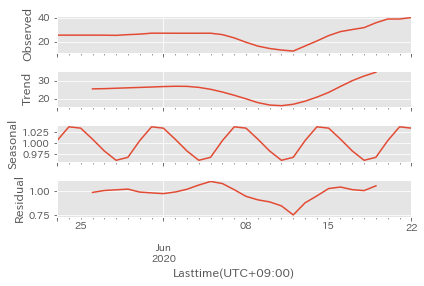

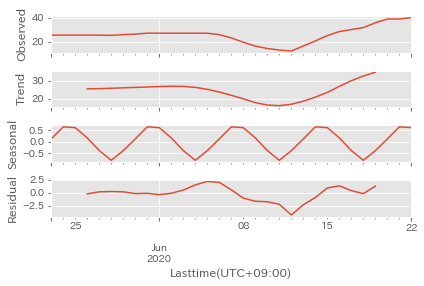

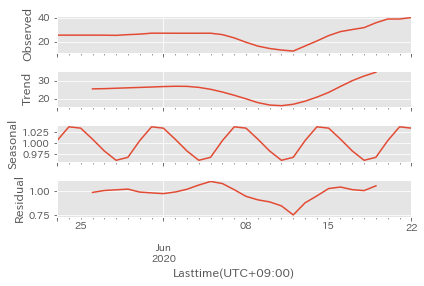

In [15]:
#time series가 additive vs multiplicative인지 확인
# 1) Latitude -> Seasonal이 일정한 형태 = additive
df1_Lat=df1_3['Latitude']
decomposition_a = sm.tsa.seasonal_decompose(df1_Lat, model="additive")
decomposition_a.plot()

decomposition_m = sm.tsa.seasonal_decompose(df1_Lat, model="multiplicative")
decomposition_m.title="multiplicative"
decomposition_m.plot()

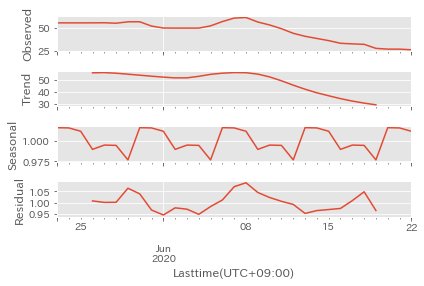

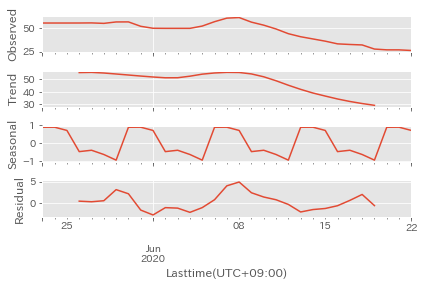

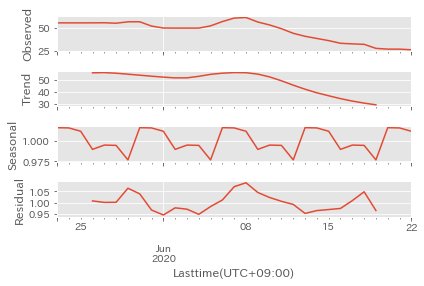

In [17]:
# 2) Longitude -> Seasonal이 일정한 형태 = additive
df1_Long=df1_3['Longitude']
decomposition_a = sm.tsa.seasonal_decompose(df1_Long, model="additive")
decomposition_a.plot()

decomposition_m = sm.tsa.seasonal_decompose(df1_Long, model="multiplicative")
decomposition_m.title="multiplicative"
decomposition_m.plot()

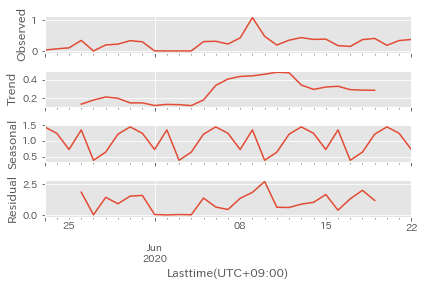

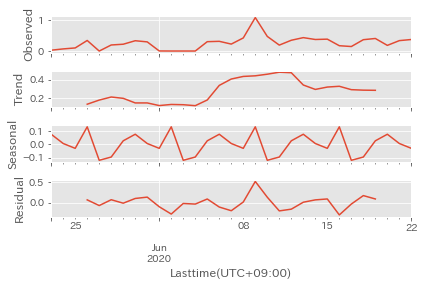

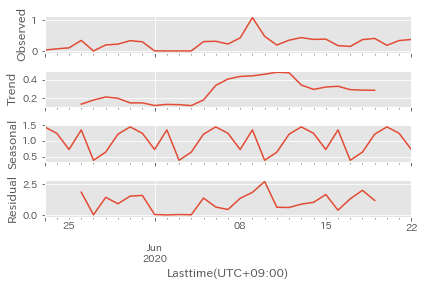

In [16]:
# 3) distance -> Seasonal이 일정한 형태 = additive
df1_dis=df1_3['Distance']
decomposition_a = sm.tsa.seasonal_decompose(df1_dis, model="additive")
decomposition_a.plot()

decomposition_m = sm.tsa.seasonal_decompose(df1_dis, model="multiplicative")
decomposition_m.title="multiplicative"
decomposition_m.plot()

ValueError: Multiplicative seasonality is not appropriate for zero and negative values

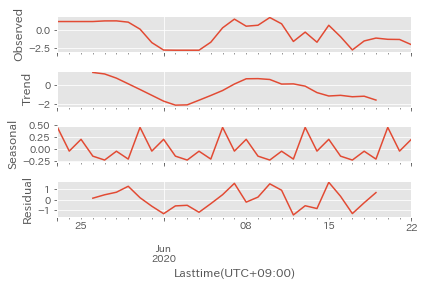

In [17]:
# 3) bearing -> multiplocative가 적용되지 않음 / Seasonal이 일정한 형태 = additive 
df1_be=df1_3['bearing']
decomposition_a = sm.tsa.seasonal_decompose(df1_be, model="additive")
decomposition_a.plot()

decomposition_m = sm.tsa.seasonal_decompose(df1_be, model="multiplicative")
decomposition_m.title="multiplicative"
decomposition_m.plot()

In [24]:
# # --------------------------목적1.6  위도경도예측 with 이동평균--------------------------
#전반적으로 [additive] 한 시계열 데이터
# ①시계열이동평균 = SARIMA(Seasonal Autoregressive Integrated Moving Average)
# 예측1: 시계열 이동평균으로, 위도/경도 예측
# 파라메터: Trend Parameter　pdq / Seasonal Parameter pdqm 

p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(df1_3.iloc[:,6],
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
            results = mod.fit()
            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

In [20]:
df1_Long=df1_3.drop(columns=['Course', 'Heading', 'Speed（船速）', 'Latitude', 'Distance','bearing'],axis=1)
df1_Lat=df1_3.drop(columns=['Course', 'Heading', 'Speed（船速）', 'Longitude', 'Distance','bearing'],axis=1)
df1_L=df1_3.drop(columns=['Course', 'Heading', 'Speed（船速）','Distance','bearing'],axis=1)

In [21]:
#latitude and longtitude
#파라메터 선택1: 정보손실지표 AIC가 낮은 파라메터 선택
#파라메터 선택2: P값과의 조정

#Latitude
df1_Lat=df1_3["Latitude"]
mod_Lat= sm.tsa.statespace.SARIMAX(df1_Lat,
                                order=(0, 1, 1),
                                seasonal_order=(1, 1, 0, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results_Lat = mod_Lat.fit()
print(results_Lat.summary().tables[1])
#Longitude
df1_Long=df1_3["Longitude"]
mod_Long= sm.tsa.statespace.SARIMAX(df1_Long,
                                order=(0, 1, 0),
                                seasonal_order=(1, 1, 0, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results_Long = mod_Long.fit()
print(results_Long.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          1.0002   1090.580      0.001      0.999   -2136.498    2138.499
ar.S.L12      -1.6816      0.518     -3.249      0.001      -2.696      -0.667
sigma2         1.1633   1268.685      0.001      0.999   -2485.415    2487.741
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L12      -1.1515      0.214     -5.391      0.000      -1.570      -0.733
sigma2         3.9804      2.464      1.615      0.106      -0.850       8.811


In [23]:
# # # predict in 10days of lat&longtitude
pred_uc_Lat = results_Lat.forecast(10)
pred_ci_Lat= pred_uc_Lat.conf_int()
pred_Lat=pred_uc_Lat.predicted_mean

pred_uc_Long = results_Long.forecast(10)
pred_ci_Long= pred_uc_Long.conf_int()
pred_Long=pred_uc_Long.predicted_mean

In [ ]:
df1_L=df1_3[["Latitude","Longitude"]]
pred_Long_Lat=pd.concat([pred_Lat,pred_Long],axis=1, sort=False)
pred_Long_Lat.columns=["pred_lat","pred_long"]

objs=[df1_L,pred_Long_Lat]
#목적1의 완성된 데이터
df_resultL=pd.concat(objs)

In [ ]:
# for mapping make plot
BBox = ((df1_1.Longitude.min(),   df1_1.Longitude.max(),      
         df1_1.Latitude.min(), df1_1.Latitude.max()))
BBox_P=((df_resultL["pred_long"].min(),df_resultL["pred_long"].max(),      
        df_resultL["pred_lat"].min(),df_resultL["pred_lat"].max()))

# BBox_P2=((pred4.pred_lon.min(),pred4.pred_lon.max(),      
#        pred4.pred_lat.min(),pred4.pred_lat.max()))

BBox_N = ((BBox_P[0], BBox[1], BBox[2], BBox_P[3]))


In [ ]:
# download backgroud map
ruh_m= plt.imread("map.png")
ruh_p= plt.imread("map_predict.png")

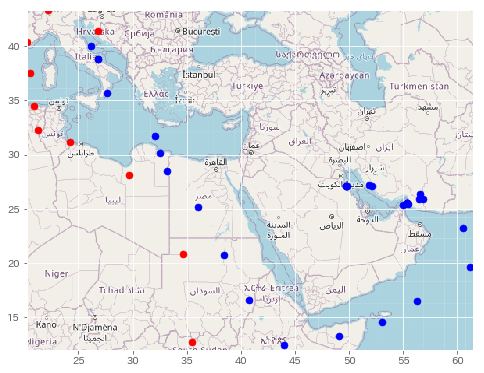

In [59]:
fig, ax = plt.subplots(figsize = (8,7))
ax.scatter(df1_3.Longitude, df1_3.Latitude, zorder=1, alpha= 1, c='b', s=50)
ax.scatter(df_resultL.pred_long, df_resultL.pred_lat, zorder=1, alpha= 1, c='r', s=50)
ax.set_title('')
ax.set_xlim(BBox_N[0],BBox_N[1])
ax.set_ylim(BBox_N[2],BBox_N[3])
ax.imshow(ruh_p, zorder=0, extent = BBox_N, aspect= 'equal')

In [ ]:
# -----------------------------목적2.0 read data---------------------------
#데이터2 선박기기데이터
df2= pd.read_csv("localpath",engine='python')  
                
# # --------------------------목적2.1 data cleansing---------------------------
#데이터1 과의 시간빈도 조정: 빈도=1day with median
c=df2.columns
df2=df2.groupby([pd.Grouper(key='Timestamp', freq='1D')])[c].median()
#지표생성에 필요한 변수만 남기기
df2_1=df2[["v1","v2"]]
# # --------------------------목적2.2  Feature Engineering--------------------------
#데이터1(위치데이터(*현 경로)) & 데이터2(기기데이터 )concat

#for concat ->  manipulate index
df1_4=df1_3.copy()
df1_4=df1_4.rename(index={"Lasttime(UTC+09:00)":"time"})
df2_1=df2_1.rename(index={"Timestamp":"time"})

df3=pd.concat([df1_4,df2_1],axis=1)
#운전 지표 생성
df3['eff']=(df3["V0"] > df3["V2"]).astype("int")

df3eff1=df3[df3["eff"]==1]
df3eff0=df3[df3["eff"]==0]

In [26]:
# ------------------목적3: 현 경로/예측 경로 가시화 및, 효율 지표 가시화 -------------------
# -------------------목적3.0 import library----------------------------------------

import chart_studio.plotly as py
from plotly.graph_objs import *
import plotly.graph_objs as go
import plotly.express as px
import plotly.io as pio
import plotly.tools as tlsM
from IPython.display import HTML,IFrame


In [ ]:
# -------------------목적3.1 필요한 데이터 준비----------------------------------------
# 데이터 1:현 경로/예측 경로 = df_resultL
# 데이터 2:효율지표 
#       효율이 좋음: df3eff1
#   효율이 좋지 않음: df3eff0

C:\Users\1181767\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:2064: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
C:\Users\1181767\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\axes\_base.py:248: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
C:\Users\1181767\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\axes\_base.py:250: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


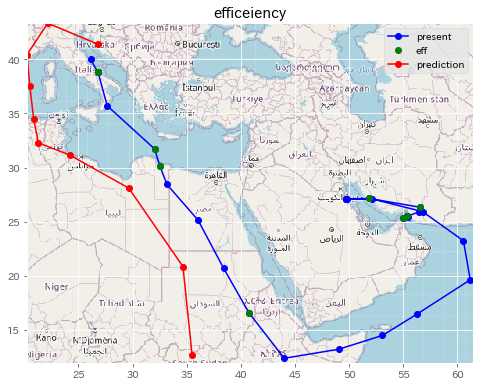

In [27]:
# download backgroud map
ruh_m= plt.imread("c:/users/localpath/map.png")
ruh_p= plt.imread("c:/users/localpath/map_predict.png")

# for mapping make plot
BBox = ((df1_1.Longitude.min(),   df1_1.Longitude.max(),      
         df1_1.Latitude.min(), df1_1.Latitude.max()))
BBox_P=((df_resultL["pred_long"].min(),df_resultL["pred_long"].max(),      
        df_resultL["pred_lat"].min(),df_resultL["pred_lat"].max()))


BBox_N = ((BBox_P[0], BBox[1], BBox[2], BBox_P[3]))


fig, ax = plt.subplots(figsize = (8,7))
ax.plot(df1_3.Longitude, df1_3.Latitude,'-o',c='b',label="present")
ax.plot(df3eff1["Longitude"], df3eff1["Latitude"],'o',c='g',label="eff")
ax.plot(df_resultL.pred_long, df_resultL.pred_lat,'-o',c="r",label="prediction")

ax.legend()
ax.set_title('efficeiency')
ax.set_xlim(BBox_P[0],BBox[1])
ax.set_ylim(BBox[2],BBox_P[3])
ax.imshow(ruh_p, zorder=0, extent = BBox_N,aspect= 'equal')

In [36]:
#---------------목적3.1.2 for dynamic plot with plotly----------------------- 
fig =go.Figure()
fig.add_trace(go.Scattermapbox(lat=list(df3.Latitude),lon=list(df3.Longitude),
                               mode="markers+lines", marker=go.scattermapbox.Marker(
            size=5
        ),subplot='mapbox',name="present",hovertemplate =df3.index))
fig.add_trace(go.Scattermapbox(lat=list(df3.pred_lat),lon=list(df3.pred_long), 
                         mode="markers+lines", marker=go.scattermapbox.Marker(
            size=5
        ),subplot='mapbox',name="prediction",hovertemplate =df3.index))
fig.add_trace(go.Scattermapbox(lat=list(df3eff1.Latitude),lon=list(df3eff1.Longitude),
                         mode="markers", marker=go.scattermapbox.Marker(
            size=5
        ),subplot='mapbox',name="eff",hovertemplate =df3eff1.index))


fig.update_layout(
    autosize=True,
    hovermode='x',
    mapbox=dict(
        style='open-street-map',
        domain={'x': [0, 1], 'y': [0, 1]},
        bearing=0,
        center=dict(
            lat=20,
            lon=61
        ),
        pitch=0,
        zoom=2
        
    )
)
fig.show()

In [ ]:
#=============================etc================================
# # 예측2: 혹은 [distance, bearing]를 예측 후, 위도/경도를 계산 (+ heading, course)
# # 결과적으로 [예측1: 시계열 이동평균으로, 위도/경도 예측] 보다 좋지않았기에 배제

# mod_heading= sm.tsa.statespace.SARIMAX(df1_3.iloc[:,1],
#                                 order=(1, 1, 0),
#                                 seasonal_order=(1, 1, 0, 12),
#                                 enforce_stationarity=False,
#                                 enforce_invertibility=False)
# results_heading = mod_heading.fit()
# # print(results_heading.summary().tables[1])

# mod_course= sm.tsa.statespace.SARIMAX(df1_3.iloc[:,0],
#                                 order=(1, 0, 1),
#                                 seasonal_order=(1, 1, 0, 12),
#                                 enforce_stationarity=False,
#                                 enforce_invertibility=False)
# results_course = mod_course.fit()
# # print(results_course.summary().tables[1])

# mod_speed= sm.tsa.statespace.SARIMAX(df1_3.iloc[:,2],
#                                 order=(0, 0, 0),
#                                 seasonal_order=(1, 1, 0, 12),
#                                 enforce_stationarity=False,
#                                 enforce_invertibility=False)
# results_speed = mod_speed.fit()
# # print(results_speed.summary().tables[1])

# mod_dis= sm.tsa.statespace.SARIMAX(df1_3.iloc[:,5],
#                                 order=(0, 0, 1),
#                                 seasonal_order=(1, 1, 0, 12),
#                                 enforce_stationarity=False,
#                                 enforce_invertibility=False)
# results_dis = mod_dis.fit()
# # print(results_dis.summary().tables[1])

# mod_bearing= sm.tsa.statespace.SARIMAX(df1_3.iloc[:,6],
#                                 order=(1, 1, 0),
#                                 seasonal_order=(0, 1, 0, 12),
#                                 enforce_stationarity=False,
#                                 enforce_invertibility=False)
# results_bearing = mod_bearing.fit()
# # print(results_bearing.summary().tables[1])
# #predict heading, course, speed,distant, bearing
# pred_uc_heading = results_heading.get_forecast(steps=10)
# pred_ci_heading= pred_uc_heading.conf_int()
# pred_heading=pred_uc_heading.predicted_mean

# pred_uc_course = results_course.get_forecast(steps=10)
# pred_ci_course= pred_uc_course.conf_int()
# pred_course=pred_uc_course.predicted_mean

# pred_uc_speed = results_speed.get_forecast(steps=10)
# pred_ci_speed= pred_uc_speed.conf_int()
# pred_speed=pred_uc_speed.predicted_mean

# pred_uc_dis = results_dis.get_forecast(steps=10)
# pred_ci_dis= pred_uc_dis.conf_int()
# pred_dis=pred_uc_dis.predicted_mean

# pred_uc_bearing = results_bearing.get_forecast(steps=10)
# pred_ci_bearing= pred_uc_bearing.conf_int()
# pred_bearing=pred_uc_bearing.predicted_mean
# pred4=pd.concat([pred_course,pred_heading,pred_speed,pred_dis,pred_bearing],axis=1, sort=False)
# pred4.columns=["pred_course","pred_heading","pred_speed","pred_dis","pred_bearing"]

# import math

# d=df1_3.Distance[30]
# lat1=math.radians(df1_3.Latitude[30])
# lon1=math.radians(df1_3.Longitude[30])
# tc=df1_3.bearing[30]
# pi=math.pi

# lat2=math.asin(math.sin(lat1)*math.cos(d/3958)+math.cos(lat1)*math.sin(d/3958)*math.cos(tc))
# lon2=lon1+math.atan2((math.sin(tc)*math.sin(d/3958)*math.cos(lat1)),
#                      (math.cos(d/3958)-math.sin(lat1)*math.sin(lat2)))

# lat3= math.degrees(lat2)
# lon3= math.degrees(lon2)

# lat=[lat3]
# lon=[lon3]
# for i in range(9):
#     d=pred4.pred_dis[i]
#     tc=pred4.pred_bearing[i]
#     lat1=math.radians(lat[i])
#     lon1=math.radians(lon[i])
#     pi=math.pi   
    
#     a=math.asin(math.sin(lat1)*math.cos(d/3958)+math.cos(lat1)*math.sin(d/3958)*math.cos(tc))
#     b=lon1+math.atan2((math.sin(tc)*math.sin(d/3958)*math.cos(lat1)),
#                            (math.cos(d/3958)-math.sin(lat1)*math.sin(a)))
    
#     a1=math.degrees(a)
#     b1=math.degrees(b)
#     lat.append(a1)
#     lon.append(b1)